## combine data as cube like object

multi_index: [year, month, day] # dimension 1
multi_column_index: [Borough, locationID] # dimension 2
value for each cube: [pickups, dropoffs, trip_distance]

In [1]:
from analysis import gen_cube
import pandas as pd
taxi_facts = pd.read_csv('data/clean/df_taxi_facts.csv')
covid = pd.read_csv('data/clean/covid.csv')

cov_facts = taxi_facts.merge(covid[['CID', 'case_count']])
c_pickup = gen_cube(taxi_facts, 'pickups', 'sum')
c_dropoffs = gen_cube(taxi_facts, 'dropoffs', 'sum')
c_distances = gen_cube(taxi_facts, 'trip_distance', 'mean')
c_cov_cases = gen_cube(cov_facts, 'case_count', 'sum')

In [29]:
c_pickup

Bronx                                                       \
                 3     20    31    32   46     47     51   58   59    60    
year month day                                                              
2020 2     29   28.0  17.0   9.0  30.0  6.0   70.0  105.0  4.0  2.0  30.0   
     3     1    29.0  17.0  11.0  34.0  2.0   44.0  112.0  2.0  1.0  35.0   
           2    51.0  73.0  13.0  67.0  6.0   91.0  149.0  5.0  2.0  48.0   
           3    62.0  75.0   7.0  70.0  7.0  112.0  169.0  7.0  5.0  58.0   
           4    66.0  68.0   7.0  85.0  6.0  116.0  172.0  7.0  4.0  57.0   
...              ...   ...   ...   ...  ...    ...    ...  ...  ...   ...   
2022 4     26   16.0  20.0   7.0  18.0  0.0   27.0   33.0  1.0  3.0  23.0   
           27   20.0  25.0   7.0  24.0  2.0   38.0   56.0  2.0  1.0  11.0   
           28   23.0  21.0   7.0  25.0  2.0   38.0   53.0  0.0  2.0  21.0   
           29   17.0  20.0   2.0  24.0  5.0   42.0   50.0  1.0  3.0  18.0   
           30    7.0  13.0   8.0  14.0  2.0   15.0   18.0  1.0  0.0  12.0   

                ... Staten Island              undefined                    \
                ...           221    245   251       18    81    102   205   
year month day  ...                                                          
2020 2     29   ...         145.0   45.0  18.0      33.0  26.0  15.0  33.0   
     3     1    ...         409.0   70.0  20.0      28.0  26.0  12.0  40.0   
           2    ...         505.0   96.0  43.0      34.0  35.0  23.0  66.0   
           3    ...         517.0   78.0  37.0      58.0  21.0  15.0  73.0   
           4    ...         478.0   85.0  42.0      45.0  38.0  18.0  67.0   
...             ...           ...    ...   ...       ...   ...   ...   ...   
2022 4     26   ...         146.0  111.0  57.0      10.0   4.0   0.0   7.0   
           27   ...         152.0   80.0  80.0       3.0   2.0   3.0   7.0   
           28   ...         144.0   77.0  57.0       3.0   6.0   2.0   9.0   
           29   ...         158.0   87.0  59.0       4.0   5.0   3.0   3.0   
           30   ...         105.0   49.0  29.0      11.0   2.0   1.0   2.0   

                                  
                 208   213   220  
year month day                    
2020 2     29   22.0  55.0  32.0  
     3     1    17.0  59.0  21.0  
           2    34.0  76.0  28.0  
           3    32.0  73.0  31.0  
           4    33.0  88.0  33.0  
...              ...   ...   ...  
2022 4     26    1.0   5.0   3.0  
           27    4.0   8.0   3.0  
           28    8.0   4.0   3.0  
           29    4.0   9.0   6.0  
           30    3.0   7.0   6.0  

[792 rows x 262 columns]

In [30]:
c_dropoffs

Bronx                                                          \
                  3      20    31    32    46     47     51    58   59    60    
year month day                                                                  
2020 2     29    28.0   57.0  20.0  47.0   9.0   98.0  140.0   7.0  4.0  57.0   
     3     1     35.0   37.0  13.0  39.0   4.0   65.0  135.0   6.0  4.0  53.0   
           2     68.0   92.0  19.0  91.0   9.0  125.0  186.0  10.0  6.0  74.0   
           3     66.0  100.0  18.0  86.0  11.0  124.0  183.0  13.0  9.0  72.0   
           4    100.0   85.0  28.0  96.0   9.0  146.0  176.0  10.0  8.0  66.0   
...               ...    ...   ...   ...   ...    ...    ...   ...  ...   ...   
2022 4     26    18.0   24.0  10.0  28.0   4.0   49.0   66.0   2.0  1.0  30.0   
           27    35.0   42.0  10.0  32.0   4.0   48.0   75.0   3.0  1.0  29.0   
           28    40.0   23.0  13.0  37.0   5.0   44.0   77.0   2.0  2.0  33.0   
           29    27.0   35.0  10.0  37.0   4.0   50.0   72.0   5.0  1.0  36.0   
           30    18.0   34.0  41.0  24.0   9.0   28.0   39.0   6.0  3.0  20.0   

                ... Staten Island              undefined                     \
                ...           221    245   251       18    81    102    205   
year month day  ...                                                           
2020 2     29   ...         240.0   80.0  44.0      72.0  32.0  65.0   93.0   
     3     1    ...         259.0   72.0  25.0      63.0  31.0  60.0   86.0   
           2    ...         281.0  117.0  49.0      62.0  38.0  53.0  102.0   
           3    ...         310.0  102.0  61.0      72.0  41.0  51.0  113.0   
           4    ...         289.0  117.0  57.0      79.0  52.0  64.0  137.0   
...             ...           ...    ...   ...       ...   ...   ...    ...   
2022 4     26   ...         130.0  101.0  59.0      24.0   7.0  28.0   46.0   
           27   ...         126.0   93.0  80.0      25.0   7.0  22.0   34.0   
           28   ...         106.0   85.0  71.0      33.0  13.0  20.0   40.0   
           29   ...         130.0  101.0  67.0      31.0  14.0  29.0   34.0   
           30   ...          89.0   40.0  33.0      23.0   7.0  24.0   28.0   

                                    
                 208    213    220  
year month day                      
2020 2     29   48.0   86.0  158.0  
     3     1    40.0   98.0  111.0  
           2    60.0  102.0  123.0  
           3    65.0   99.0  126.0  
           4    56.0  101.0  141.0  
...              ...    ...    ...  
2022 4     26   21.0   24.0   51.0  
           27   16.0   27.0   59.0  
           28   20.0   30.0   56.0  
           29   18.0   26.0   51.0  
           30   17.0   40.0   60.0  

[792 rows x 262 columns]

In [31]:
c_distances

Bronx                                              \
                      3          20         31         32         46    
year month day                                                          
2020 2     29    6.752974   6.752974   6.752974   6.752974   6.752974   
     3     1     4.437438   4.437438   4.437438   4.437438   4.437438   
           2     4.352602   4.352602   4.352602   4.352602   4.352602   
           3     5.152849   5.152849   5.152849   5.152849   5.152849   
           4     7.617369   7.617369   7.617369   7.617369   7.617369   
...                   ...        ...        ...        ...        ...   
2022 4     26   12.864473  12.864473   7.633822  12.864473   8.389263   
           27    5.382056  89.130133  89.130133   5.382056   5.382056   
           28   30.857413  30.857413  30.857413   7.266788   7.266788   
           29   64.088870  64.088870  64.088870  64.088870   8.019914   
           30    5.680668  36.161326  36.161326  36.161326  36.161326   

                                                                     ...  \
                      47         51        58        59         60   ...   
year month day                                                       ...   
2020 2     29    6.752974   6.752974  6.752974  4.452069   6.752974  ...   
     3     1     4.437438   4.437438  4.437438  4.437438   4.437438  ...   
           2     4.352602   4.352602  4.352602  4.352602   4.352602  ...   
           3     5.152849   5.152849  5.152849  5.749284   5.152849  ...   
           4     7.617369   7.617369  7.617369  7.617369   7.617369  ...   
...                   ...        ...       ...       ...        ...  ...   
2022 4     26   12.864473  12.864473  7.633822  6.878380  12.864473  ...   
           27   89.130133  89.130133  5.382056  6.901912  89.130133  ...   
           28   30.857413  30.857413  7.266788  7.009232  30.857413  ...   
           29   64.088870  64.088870  8.019914  6.716582  64.088870  ...   
           30   36.161326  36.161326  5.680668  5.680668  36.161326  ...   

               Staten Island                       undefined              \
                         221       245       251         18          81    
year month day                                                             
2020 2     29       6.752974  4.452069  4.452069    7.004084    7.004084   
     3     1        4.922083  6.464377  4.922083    3.423969    3.423969   
           2        4.824271  4.824271  4.824271    3.211679    3.211679   
           3        5.333331  5.333331  5.333331    4.375933    4.375933   
           4        4.708832  4.708832  7.617369    8.110295    8.110295   
...                      ...       ...       ...         ...         ...   
2022 4     26       7.633822  7.633822  7.633822   15.857519   15.857519   
           27       5.382056  5.382056  5.382056  130.244244  130.244244   
           28       7.266788  7.266788  7.266788   42.781504   42.781504   
           29      64.088870  6.716582  8.019914   92.775015   92.775015   
           30       5.680668  6.490900  5.680668   50.996540    4.870435   

                                                                            
                       102         205         208         213         220  
year month day                                                              
2020 2     29     7.004084    7.004084    7.004084    7.004084    7.004084  
     3     1      3.423969    3.423969    3.423969    3.423969    3.423969  
           2      3.211679    3.211679    3.211679    3.211679    3.211679  
           3      4.375933    4.375933    4.375933    4.375933    4.375933  
           4      8.110295    8.110295    8.110295    8.110295    8.110295  
...                    ...         ...         ...         ...         ...  
2022 4     26    15.857519   15.857519   15.857519    8.389263   15.857519  
           27   130.244244  130.244244  130.244244  130.244244  130.244244  
           28    42.

In [4]:
c_cov_cases

case_count
year month day            
2020 2     29          3.0
     3     1           0.0
           2           0.0
           3           3.0
           4          15.0
...                    ...
2022 4     26       8832.0
           27       5580.0
           28       8004.0
           29       8361.0
           30       3236.0

[792 rows x 1 columns]

In [ ]:
import plotly.express as px


In [11]:
# Plot
fig = px.line(c_cov_cases, x='case_count')

#fig.add_scatter(x=df['Date'], y=df['AAPL.Low']) # Not what is desired - need a line

# Show plot
fig.show()

TypeError: Argument 'y' is a pandas MultiIndex. pandas MultiIndex is not supported by plotly express at the moment.

In [ ]:
import matplotlib as plt
ax = c_cov_cases.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(12, 7), layout=(2, 3))
plt.tight_layout()

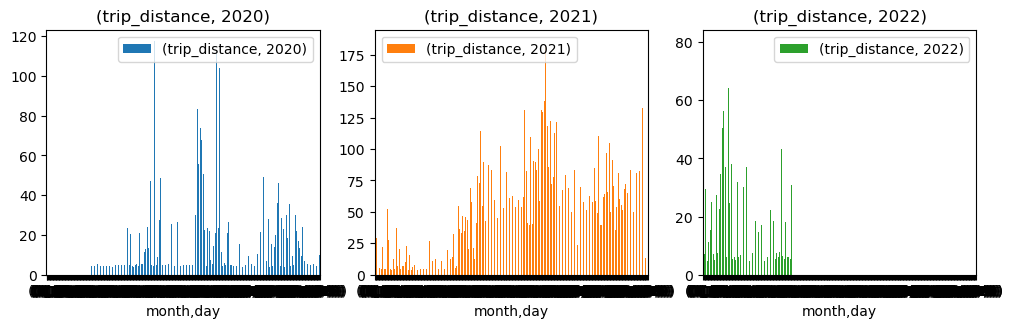

In [ ]:
df = c_distances.groupby(level=0, axis=1).sum()
ax = df.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(12, 7), layout=(2, 3))
plt.tight_layout()

NameError: name 'plt' is not defined

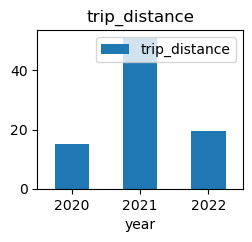

In [4]:
dfp = df.pivot_table(index='year', values=df.columns, aggfunc='mean')

dfp.plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(3, 3))
plt.tight_layout()